In [1]:
from torch.utils.data import Dataset, DataLoader, Sampler
from typing import Any, Callable, List, Optional, Sequence, Tuple, Union
import torch.nn.functional as F
import pandas as pd
import torch.nn as nn
import torch
from tqdm import tqdm
import numpy as np
import os
import sys
from datetime import date, timedelta
import gc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import random
import requests
from math import sqrt
import math
import yaml
import traceback
import pickle

In [18]:
class DataBase:
    def __init__(self,
                start_train_date: str,
                end_train_date: str,
                start_test_date: str,
                end_test_date: str,
                data_dir: str,
                hour_forecast = 3,
                lookback_days = 7,
                batch_size = 32,
                train_shuffle = True,
                val_shuffle = False,
                cv = True,
                k = 5,
                trading_hub = 'Houston',
                train_split = 0.7,
                predict_variable = 'ACTUAL_ERC_HLoad_excessive'
                ):
        

        self.start_train_date = start_train_date
        self.end_train_date = end_train_date
        self.start_test_date = start_test_date
        self.end_test_date = end_test_date
        self.data_dir = data_dir

        self.batch_size = batch_size
        self.train_shuffle = train_shuffle
        self.val_shuffle = val_shuffle
        self.cv = cv
        self.k = k
        self.trading_hub = trading_hub
        self.train_split = train_split
        self.predict_variable = predict_variable


        self.price_data_path = f'{data_dir}/2023_24_ERCOT_forecast_actual_data_v3.csv'

        self.hour_forecast = hour_forecast
        self.lookback_days = lookback_days

        self.variable_selected = ['ACTUAL_ERC_Load', 'ACTUAL_ERC_HLoad', 'ACTUAL_ERC_NLoad',
                                    'ACTUAL_ERC_SLoad', 'ACTUAL_ERC_WLoad', 'ACTUAL_ERC_CWind',
                                    'ACTUAL_ERC_NWind', 'ACTUAL_ERC_PWind', 'ACTUAL_ERC_SWind',
                                    'ACTUAL_ERC_Wind', 'ACTUAL_ERC_WWind', 'ACTUAL_ERC_Solar',
                                    f'SP_Price_{trading_hub}',f'DA_Price_{trading_hub}']


    def _get_date_list(self, start_date, end_date):
        '''
        Get date list between start_date and end_date in forat "yyyymmdd"
        '''
        start_date = datetime.strptime(start_date, "%Y%m%d")
        end_date = datetime.strptime(end_date, "%Y%m%d")
        date_list = []
        
        while start_date <= end_date:
            date_list.append(start_date.strftime("%Y%m%d"))
            start_date += timedelta(days=1)

        return date_list
    
    def _get_price_data(self):
        self.price_data_df = pd.read_csv(self.price_data_path)

        

        self.hub = self.price_data_df.loc[:,['marketday', 'hourending'] + self.variable_selected].copy()

        self.hub.loc[:,f'{self.trading_hub}_DART'] = self.hub.loc[:,f'SP_Price_{self.trading_hub}'] - self.hub.loc[:,f'DA_Price_{self.trading_hub}']
        self.hub['date_int'] = pd.to_datetime(self.hub['marketday'], format='%m/%d/%Y').dt.strftime('%Y%m%d').astype(int)

        self.hub.index = self.hub['date_int'] * 100 + self.hub['hourending'].astype(int)
        #calculate the excessive value
        for value in self.variable_selected + [f'{self.trading_hub}_DART']:
            hour_group_mean = self.hub.groupby('hourending')[value].rolling(self.lookback_days).mean().reset_index().rename(columns={value:f'{value}_mean',
                                                                                                                                                  'level_1':'timestamp'})
            # print(hour_group_mean[hour_group_mean['hourending'] == 2].iloc[:10,:])
            hour_group_mean.index = hour_group_mean.timestamp
            hour_group_std = self.hub.groupby('hourending')[value].rolling(self.lookback_days).std().reset_index().rename(columns={value:f'{value}_std',
                                                                                                                                                  'level_1':'timestamp'})
            hour_group_std.index = hour_group_std.timestamp
            # self.houston = self.houston.merge(hour_group_mean.loc[:,[f'{value}_mean','timestamp']], on=['timestamp'], how='left')
            self.hub  = pd.concat([self.hub, hour_group_mean.loc[:,[f'{value}_mean']],hour_group_std.loc[:,[f'{value}_std']]], axis=1)
            
            self.hub[f'{value}_excessive'] = (self.hub[value] - self.hub[f'{value}_mean']) / self.hub[f'{value}_std']
            
            # print(self.houston[self.houston['date_int'] == 20230201])
            
            # raise Exception('stop')
        self.hub.loc[:,'datetime'] = self.hub.index
        self.hub = self.hub.dropna()

        #get all the unique dates
        all_dates = self.hub['date_int'].unique()

        #create a dataframe with date_int and hour_ending 1-24
        all_hours = range(1, 25)  # Hours 1-24
        multi_index = pd.MultiIndex.from_product(
                                                    [all_dates, all_hours],
                                                    names=['date_int', 'hourending']
                                                )
        
        self.hub = (
                        self.hub.set_index(['date_int', 'hourending'])
                        .reindex(multi_index)
                        .reset_index()
                    )

        # Sort by date and hourending (optional)
        self.hub.sort_values(['date_int', 'hourending'], inplace=True)

        self.hub = self.hub.ffill()
        # print(self.hub[self.hub['marketday'] == '2/15/2023'])

    def _get_date_one_days_later(self,date_str):
        # Convert string to datetime object
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        
        # Add two days
        future_date_obj = date_obj + timedelta(days=1)
        
        # Convert back to string in YYYYMMDD format
        future_date_str = future_date_obj.strftime("%Y%m%d")
    
        return future_date_str
    
    def _get_date_x_days_before(self,date_str,x=1):
        # Convert string to datetime object
        date_obj = datetime.strptime(date_str, "%Y%m%d")

        past_date_obj = date_obj - timedelta(days=x)
        
        # Convert back to string in YYYYMMDD format
        past_date_str = past_date_obj.strftime("%Y%m%d")
    
        return past_date_str
    


    def _get_data_list(self,modes):
        weather_data_list = []
        time_series_lookback_list = []
        time_series_forecast_list = []

        if modes == 'train':
            self.date_list = self._get_date_list(self.start_train_date, self.end_train_date)
        elif modes == 'test':
            self.date_list = self._get_date_list(self.start_test_date, self.end_test_date)
        else:
            raise ValueError('modes should be either train or test')

        for date_str in self.date_list:
            date = int(date_str)

            yesterday = self._get_date_x_days_before(date_str,x=1)

            start_lookback_date = self._get_date_x_days_before(date_str,x=self.lookback_days+1)
            
            #get the time series data
            time_series_lookback = self.hub.loc[(self.hub['date_int'] < int(yesterday))].copy()
            date_unique = time_series_lookback['date_int'].unique()

            if len(date_unique) < self.lookback_days:
                continue

            time_series_lookback = time_series_lookback[time_series_lookback['date_int'].isin(date_unique[-self.lookback_days:])]
            

            time_series_forecast = self.hub.loc[self.hub['date_int'] == date].copy()

            if len(time_series_forecast) == 0:
                continue

            # print(self.hub[self.hub['marketday'] == '2/15/2023'])
            # print(date_str)
            # print(time_series_lookback.date_int.unique())
            # print(time_series_lookback)
            # print(time_series_forecast)
            # raise ValueError

            forecast_date = self._get_date_one_days_later(date_str)
            weather_data_path = f'{self.data_dir}/GFS_forecast/forecast_{date}_on_{yesterday}.pkl'
            # print(weather_data_path)
            with open(weather_data_path, 'rb') as file:
                daily_weather_data = pickle.load(file)

            # print(daily_weather_data.keys())
            #print(daily_weather_data['data'].shape)


            prediction_frequency = len(daily_weather_data['hour_forecast']) 
            if prediction_frequency * self.hour_forecast != 24:
                raise ValueError(f'hour_forecast len {prediction_frequency} or {self.hour_forecast} not correct')

            for i in range(prediction_frequency):
                #print(len(time_series_lookback))
                # if '3/12/2023' in time_series_lookback.marketday.values:
                #     print(len(time_series_lookback))
                #     print(time_series_lookback[time_series_lookback.marketday == '3/12/2023'])
                #     print(time_series_lookback.groupby('marketday').count())
                #     raise Exception('stop')
                time_series_lookback_list.append(time_series_lookback)
                time_series_forecast_list.append(time_series_forecast.iloc[i*self.hour_forecast:(i+1)*self.hour_forecast])
                # print(len(time_series_forecast.iloc[i*self.hour_forecast:(i+1)*self.hour_forecast]))
                weather_data_list.append(daily_weather_data['data'][i,:,:,:])

                # print(self.time_series_forecast_list[0].datetime)
                # print(self.time_series_lookback_list[0])                

                # raise Exception('stop')
            # print(len(self.weather_data_list))
            # print(len(self.time_series_lookback_list))
            # print(len(self.time_series_forecast_list))
        return weather_data_list, time_series_lookback_list, time_series_forecast_list  

    def create_dataloader(self):

        self._get_price_data()

        weather_data_list_train, time_series_lookback_list_train, time_series_forecast_list_train  = self._get_data_list(modes='train')
        filtered_index = list(range(len(weather_data_list_train)))

        if self.cv:
            samples_in_fold = len(filtered_index)// self.k
            split = int(samples_in_fold*self.train_split)

            trainning_index_all = []
            validation_index_all = []

            for i in range(self.k):
                trainning_index = filtered_index[i*samples_in_fold:i*samples_in_fold+split]
                validation_index = filtered_index[i*samples_in_fold+split:(i+1)*samples_in_fold]

                trainning_index_all = trainning_index_all + list(trainning_index)
                validation_index_all = validation_index_all + list(validation_index)
        else:
            split = int(len(filtered_index)*self.train_split)

            trainning_index_all = list(filtered_index[:split])
            validation_index_all = list(filtered_index[split:])

        excess_variables = [f'{v}_excessive' for v in self.variable_selected + [f'{self.trading_hub}_DART']]

        all_variables = self.variable_selected + excess_variables + [f'{self.trading_hub}_DART']

        trainning_dataset = BTDataset(weather_data_list_train, time_series_lookback_list_train, time_series_forecast_list_train, trainning_index_all, all_variables, self.predict_variable)
        trainning_dataloader = DataLoader(trainning_dataset, batch_size=self.batch_size, shuffle=self.train_shuffle)

        validation_dataset = BTDataset(weather_data_list_train, time_series_lookback_list_train, time_series_forecast_list_train, validation_index_all, all_variables, self.predict_variable)
        validation_dataloader = DataLoader(validation_dataset, batch_size=self.batch_size, shuffle=self.val_shuffle)
        
        return trainning_dataloader, validation_dataloader
        
        

class BTDataset(Dataset):
    def __init__(self,
                 weather_data_list,
                 time_series_lookback_list,
                 time_series_forecast_list,
                 filtered_index,
                 feature_required,
                 predict_value,
                 ):
        super().__init__()
        self.weather_data_list = weather_data_list
        self.time_series_lookback_list = time_series_lookback_list
        self.time_series_forecast_list = time_series_forecast_list
        self.index_list = filtered_index
        self.feature_required = feature_required
        self.predict_value = predict_value

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, index):

        sample_index = self.index_list[index]
        time_series_lookback_df = self.time_series_lookback_list[sample_index]
        time_series_forecast_df = self.time_series_forecast_list[sample_index]
        weather_data = self.weather_data_list[sample_index]

        raw_data_ts = time_series_lookback_df.loc[:,self.feature_required].copy().values
        raw_data_weather = weather_data.copy()
        label = time_series_forecast_df.loc[:,self.predict_value].values

        train_month = time_series_lookback_df['date_int'].values // 100 %100
        train_day = time_series_lookback_df['date_int'].values % 100 
        train_hour = time_series_lookback_df['hourending'].values

        label_month = time_series_forecast_df['date_int'].values // 100 %100
        label_day = time_series_forecast_df['date_int'].values % 100 
        label_hour = time_series_forecast_df['hourending'].values
        
        # print(time_series_lookback_df['date_int'].values)
        # print(train_month)
        # print(train_day)
        # print(train_hour)

        # print(label_month)
        # print(label_day)
        # print(label_hour)
        # raise ValueError
        # print(raw_data_ts.shape)
        # print(raw_data_weather.shape)
        # print(label.shape)
        return {'raw_data_ts':torch.from_numpy(raw_data_ts).float(),
                'train_month':torch.from_numpy(train_month).long(),
                'train_day':torch.from_numpy(train_day).long(),
                'train_hour':torch.from_numpy(train_hour).long(),
                'raw_data_weather':torch.from_numpy(raw_data_weather).float(),
                'label':torch.from_numpy(label).float(),
                'label_month':torch.from_numpy(label_month).long(),
                'label_day':torch.from_numpy(label_day).long(),
                'label_hour':torch.from_numpy(label_hour).long(),
                }



In [19]:
database = DataBase(start_train_date='20230201',
                    end_train_date='20230328',
                    start_test_date='20230301',
                    end_test_date='20230331',
                    data_dir='/Users/leroy/Documents/GitHub/Electricity_trading/DART/Data')

trainning_dataloader, validation_dataloader = database.create_dataloader()

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------------------------------------------------
# 1) A small CNN to extract local features in (C, H, W)
# -------------------------------------------------------------------------
class SimpleCNN(nn.Module):
    """
    A small CNN block to process input weather data (B, 16, H, W) into (B, embed_dim, H, W).
    You can expand with more layers, skip connections, etc. for better performance.
    """
    def __init__(self, in_channels=16, out_channels=32):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        # x: (B, in_channels, H, W)
        return self.conv_block(x)  # => (B, out_channels, H, W)

# -------------------------------------------------------------------------
# 1) DateTime Embedding
# -------------------------------------------------------------------------
class DateTimeEmbedding(nn.Module):
    """
    Embeds (month, day, hour) each of shape (batch_size, 3)
    into a single vector of shape (batch_size, embed_dim).
    """
    def __init__(self, embed_dim=16):
        super().__init__()
        self.month_embed = nn.Embedding(12, embed_dim)
        self.day_embed   = nn.Embedding(31, embed_dim)
        self.hour_embed  = nn.Embedding(24, embed_dim)
        
    def forward(self, month, day, hour):
        month = month - 1
        day = day - 1
        hour = hour - 1
        # Each is (batch_size, 3). We embed them individually:
        # month_embed(month) => (batch_size, 3, embed_dim)
        
        month_emb = self.month_embed(month).mean(dim=1)  # => (batch_size, embed_dim)
        day_emb   = self.day_embed(day).mean(dim=1)      # => (batch_size, embed_dim)
        hour_emb  = self.hour_embed(hour).mean(dim=1)    # => (batch_size, embed_dim)
        
        # Combine them by summation (or you can concat and do a small MLP)
        
        combined = month_emb + day_emb + hour_emb
        return combined  # => (batch_size, embed_dim)


# -------------------------------------------------------------------------
# 2) Spatial Positional Encoding in 2D form
# -------------------------------------------------------------------------
class SpatialPositionalEncoding2D(nn.Module):
    """
    A 2D positional encoding for an 8x9 grid.
    - row_embed has shape (8, embed_dim)
    - col_embed has shape (9, embed_dim)
    We sum row_embed[row] + col_embed[col] to get a unique embedding
    for each (row, col).
    """
    def __init__(self, grid_size=(8, 9), embed_dim=16):
        super().__init__()
        self.H, self.W = grid_size
        self.row_embed = nn.Embedding(self.H, embed_dim)
        self.col_embed = nn.Embedding(self.W, embed_dim)

    def forward(self):
        """
        Returns a 2D positional encoding of shape (embed_dim, H, W).
        Typically you'd add this to your feature map of shape (B, embed_dim, H, W).
        """
        device = self.row_embed.weight.device
        
        # row indices: 0..(H-1), col indices: 0..(W-1)
        rows = torch.arange(self.H, device=device)  # shape (H,)
        cols = torch.arange(self.W, device=device)  # shape (W,)
        
        # row_embed(rows) => (H, embed_dim)
        # col_embed(cols) => (W, embed_dim)
        row_emb = self.row_embed(rows)  # (H, embed_dim)
        col_emb = self.col_embed(cols)  # (W, embed_dim)
        
        # Sum: broadcast to (H, W, embed_dim), then transpose to (embed_dim, H, W)
        # row_emb => (H, 1, embed_dim)
        # col_emb => (1, W, embed_dim)
        # out => (H, W, embed_dim) => permute => (embed_dim, H, W)
        pos_2d = row_emb.unsqueeze(1) + col_emb.unsqueeze(0)  # (H, W, embed_dim)
        pos_2d = pos_2d.permute(2, 0, 1)  # => (embed_dim, H, W)
        return pos_2d


# -------------------------------------------------------------------------
# 3) Attention-based Pooling over the flattened tokens
# -------------------------------------------------------------------------
class AttentionPool(nn.Module):
    """
    Learns a linear 'query' that produces a scalar attention score for each token.
    Then uses softmax to get attention weights, and outputs a weighted sum.
    """
    def __init__(self, embed_dim=16):
        super().__init__()
        self.attn_query = nn.Linear(embed_dim, 1)  # (embed_dim) -> scalar

    def forward(self, x):
        """
        x: (batch_size, seq_len, embed_dim)
        returns (batch_size, embed_dim)
        """
        # attn_logits => (batch_size, seq_len, 1)
        attn_logits = self.attn_query(x)
        attn_logits = attn_logits.squeeze(-1)  # => (batch_size, seq_len)
        
        attn_weights = F.softmax(attn_logits, dim=-1).unsqueeze(-1)  # => (batch_size, seq_len, 1)
        pooled = (x * attn_weights).sum(dim=1)  # => (batch_size, embed_dim)
        return pooled


# -------------------------------------------------------------------------
# 4) Transformer Model with "Apply 2D Pos Encoding, then Flatten"
# -------------------------------------------------------------------------
class TransformerModel2D(nn.Module):
    """
    Demonstrates how to:
      - Keep the data in (B, C, H, W) shape initially.
      - Apply a 1x1 conv (or linear) to project from 16 -> embed_dim in 2D form.
      - Add the 2D positional embeddings (embed_dim, H, W).
      - Flatten to (B, H*W, embed_dim).
      - Add the temporal embedding (month/day/hour).
      - Pass through Transformer.
      - Use attention-based pooling for a final single embedding.
    """
    def __init__(self, 
                 input_dim=16,   # raw weather feature channels
                 embed_dim=16, 
                 num_heads=4, 
                 num_layers=3, 
                 grid_size=(8,9)):
        super().__init__()
        
        self.grid_size = grid_size  # (H=8, W=9)
        self.embed_dim = embed_dim
        
        # 2D positional encoder (returns (embed_dim, H, W))
        self.spatial_pe_2d = SpatialPositionalEncoding2D(grid_size, embed_dim)
        
        # 1x1 conv to project from input_dim -> embed_dim while preserving H,W
        # If input_dim == embed_dim, you could skip this layer or make it an identity.
        # self.feature_projection = nn.Conv2d(
        #     in_channels=input_dim, 
        #     out_channels=embed_dim,
        #     kernel_size=1, 
        #     bias=False
        # )

        self.feature_projection = SimpleCNN(in_channels=input_dim, out_channels=embed_dim)

        # Embedding for (month, day, hour) => (batch_size, embed_dim)
        # self.datetime_embed = DateTimeEmbedding(embed_dim)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Attention-based pooling
        self.attn_pool = AttentionPool(embed_dim)

    def forward(self, x, time_emb):
        """
        x: shape (batch_size, 16, 8, 9)
        month/day/hour: (batch_size, 3)
        """
        #minus 1 to make the month and day and hour start from 0
        # month = month - 1
        # day = day - 1
        # hour = hour - 1
        
        B, C, H, W = x.shape
        assert (H, W) == self.grid_size, "Input grid size must match the set grid_size."

        # 1) Project input features to embed_dim in 2D form:
        #    (B, 16, 8, 9) -> (B, embed_dim, 8, 9)
        x_proj = self.feature_projection(x)  # => (B, embed_dim, 8, 9)

        # 2) Get 2D positional embedding => shape (embed_dim, 8, 9)
        pos_2d = self.spatial_pe_2d()  # => (embed_dim, 8, 9)

        # 3) Broadcast and add => (B, embed_dim, 8, 9)
        #   pos_2d is (embed_dim, H, W). We add it to each batch example.
        x_proj = x_proj + pos_2d.unsqueeze(0)  # broadcast over batch

        # 4) Flatten spatial dimension => (B, embed_dim, 8*9) => (B, 72, embed_dim)
        x_proj = x_proj.view(B, self.embed_dim, -1).permute(0, 2, 1)
        # shape now: (batch_size, 72, embed_dim)

        # 5) Embed the date/time => (B, embed_dim)
        #directly use the time embedding
        # time_emb = self.datetime_embed(month, day, hour)  # => (B, embed_dim)


        # Expand to (B, 1, embed_dim) and broadcast to the 72 tokens
        time_emb_2d = time_emb.unsqueeze(1).expand(-1, x_proj.size(1), -1)  # => (B, 72, embed_dim)

        # 6) Combine the time embedding with the spatially encoded tokens
        x_proj = x_proj + time_emb_2d  # add or could use another projection

        # 7) Pass through Transformer
        out = self.transformer_encoder(x_proj)  # => (B, 72, embed_dim)

        # 8) Apply attention-based pooling => (B, embed_dim)
        pooled = self.attn_pool(out)

        return pooled

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask
    
class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            # the potential to take covariates (e.g. timestamps) as tokens
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1)) 
        # x: [Batch Variate d_model]
        return self.dropout(x)
    

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
    
class IT(nn.Module):
    """
    Paper link: https://arxiv.org/abs/2310.06625
    """

    def __init__(self, 
                 seq_len,
                 d_model,
                 n_heads,
                 dropout=0.1,
                 d_ff=2048,
                 activation = 'gelu',
                 e_layers = 2):
        super(IT, self).__init__()
        self.seq_len = seq_len
        # Embedding
        self.enc_embedding = DataEmbedding_inverted(seq_len, d_model, embed_type='fixed', freq='h',
                                                    dropout=dropout)
        # Encoder-only architecture
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, factor=5, attention_dropout=dropout,
                                      output_attention=False), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        # print(means.shape)
        x_enc =  x_enc - means

        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc = x_enc / stdev

        _, _, N = x_enc.shape # B L N
        # B: batch_size;    E: d_model; 
        # L: seq_len;       S: pred_len;
        # N: number of variate (tokens), can also includes covariates

        # Embedding
        # B L N -> B N E                (B L N -> B L E in the vanilla Transformer)
        enc_out = self.enc_embedding(x_enc, x_mark_enc) # covariates (e.g timestamp) can be also embedded as tokens
        # print(enc_out[0,:,:])
        # B N E -> B N E                (B L E -> B L E in the vanilla Transformer)
        # the dimensions of embedded time series has been inverted, and then processed by native attn, layernorm and ffn modules
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        
        enc_out = enc_out.mean(1)
        return enc_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out # [B, D]
    
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim, n_heads, dropout=0.1):
        super(CrossAttentionFusion, self).__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, n_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, query, key, value):
        # query: (B*pred_hours, 1, embed_dim)
        # key, value: (B*pred_hours, 2, embed_dim)
        attn_output, _ = self.cross_attn(query, key, value)
        query = self.norm1(query + attn_output)
        ffn_output = self.ffn(query)
        out = self.norm2(query + ffn_output)
        return out


# ============================================================================
# 5) Combined Predictor Model
#    Uses cross-attention fusion (with residual connections) to fuse the weather
#    and load latent representations based on target forecast time.
# ============================================================================
class CombinedGridLoadPredictor(nn.Module):
    def __init__(self, config):
        """
        weather_encoder: instance of TransformerModel2D (weather branch)
        load_encoder: instance of ITEncoder (load branch)
        latent_dim: shared embedding dimension (e.g., 32)
        grid_size: (H, W) of the grid
        pred_hours: number of forecast hours (e.g., 3)
        datetime_embed: shared DateTimeEmbedding instance
        """
        super(CombinedGridLoadPredictor, self).__init__()
        self.weather_encoder = TransformerModel2D(
                                                input_dim=config['input_dim'], 
                                                embed_dim=config['embed_dim'],  # let’s go bigger internally
                                                num_heads=config['n_heads'], 
                                                num_layers=config['tf_num_layers'], 
                                                grid_size=config['grid_size']
                                            )
        self.load_encoder = IT(
                                seq_len=config['seq_len'],
                                d_model=config['embed_dim'],
                                n_heads=config['n_heads'],
                                dropout=config['dropout'],
                                d_ff=int(config['embed_dim'] * 2),
                            )
        
        self.datetime_embed = DateTimeEmbedding(embed_dim=config['embed_dim'])
        
        # Cross-attention fusion block.
        # For each forecast hour, we form key/value from stacked weather and load latents.
        self.cross_attn_fusion = CrossAttentionFusion(embed_dim=config['embed_dim'], n_heads=config['n_heads'])
        
        #output layer
        self.out_layer = nn.Linear(config['embed_dim'], config['pred_hours'])
    
    def forward(self, batch):
        """
        weather_data: (B, 16, 8, 9)
        weather_time_info: (B, pred_hours, 3) for the weather forecast times
        load_x_enc: (B, 168, 20)
        load_x_mark_enc: (B, 168, 3)
        target_time_info: (B, pred_hours, 3) for the downstream target times
        """
        weather_data = batch['raw_data_weather']
        pred_month = batch['label_month']
        pred_day = batch['label_day']
        pred_hour = batch['label_hour']

        ts_data = batch['raw_data_ts']
        ts_month = batch['train_month']
        ts_day = batch['train_day']
        ts_hour = batch['train_hour']

        B = weather_data.size(0)
        # External embeddings using the shared DateTimeEmbedding
        target_time_emb = self.datetime_embed(pred_month, pred_day, pred_hour) # (B, latent_dim)
        
        # Weather branch: produce weather latent per forecast hour → (B, latent_dim)
        weather_latent = self.weather_encoder(weather_data, target_time_emb)

        #create x_mark for the load encoder
        load_x_mark_enc = torch.cat([ts_month.unsqueeze(-1), ts_day.unsqueeze(-1), ts_hour.unsqueeze(-1)], dim=-1) # (B, T, 3)
        
        # Load branch: produce a single latent → (B, latent_dim); replicate for forecast hours.
        load_latent = self.load_encoder(ts_data, load_x_mark_enc, None, None)  # (B, latent_dim)
        

        
        # For each forecast hour, form a key-value pair by stacking the two latents.
        # keys: (B, 2, latent_dim)
        keys = torch.stack([weather_latent, load_latent], dim=1)

        # Query: use target time embedding for each forecast hour → (B, 1, latent_dim)
        query = target_time_emb.unsqueeze(1)
        
        # Apply cross-attention fusion
        fused = self.cross_attn_fusion(query, keys, keys)  # (B*pred_hours, 1, latent_dim)
        
        #get prediction
        pred = self.out_layer(fused.squeeze(1))
        
        return {'pred':pred}


In [85]:
class Trainner:
    def __init__(self,
                 model,
                 optim,
                 scaler,
                 device,
                 lr,
                 loss_fn,
                 trainning_dataloader,
                 validation_dataloader,
                 testing_dataloader,
                 scheduler_name = None,
                 scheduler_max_step = 20,
                 scheduler_min_lr = 1e-9,
                 max_epoch = 50,
                 exit_count = 15,
                 model_name = 'best_model_weights.pt',
                 output_filaname = 'output.txt',
                 loss_plot = 'loss.png',
                 show = True,
                 gradient_clip = True,
                 max_gradient_norm = 1,
                 gamma = 2,
                 poly_power = 2,
                 mixed_percision_type = torch.bfloat16
                 ):
        '''
        This Trainer class handles the model training, validation, and testing process. 
        It supports various learning rate schedules, gradient clipping, mixed precision training, 
        and backtesting of the model performance.
        '''
        
        # Initialize model, optimizers, dataloaders, and training settings
        self.model = model.to(device)
        self.trainning_dataloader = trainning_dataloader
        self.validation_dataloader = validation_dataloader
        self.testing_dataloader = testing_dataloader
        self.device = device
        self.optim = optim
        self.loss_fn = loss_fn
        self.lr = lr
        self.scheduler_name = scheduler_name
        self.max_epcoh = max_epoch
        self.exit_count = exit_count
        self.validation_loss_list = []
        self.trainning_loss_list = []
        self.model_name = model_name
        self.output_filaname = output_filaname
        self.show = show
        self.gradient_clip = gradient_clip
        self.max_gradient_norm = max_gradient_norm
        self.scaler = scaler
        self.mixed_percision_type = mixed_percision_type
        self.loss_plot = loss_plot
    
        # Learning rate scheduler
        if self.scheduler_name == 'cos':
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optim, T_max=scheduler_max_step, eta_min=scheduler_min_lr)

        elif self.scheduler_name == 'expo':
            self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=gamma)

        elif self.scheduler_name == 'poly':
            self.scheduler = torch.optim.lr_scheduler.PolynomialLR(self.optim, power=poly_power,total_iters=max_epoch)


    def log_print(self,out):
        '''
        Print logs to both console and output file (if `self.show` is True).
        '''
        if self.show:
            with open(self.output_filaname, "a") as f:
                print(out, file=f)
                print(out)

    def validation(self):
        '''
        Run validation on the validation dataset and return the average loss.
        This function also computes the Sharpe ratio and PnL per trade for validation.
        '''

        loss_list = []
        element_loss = []

        # Disable gradient calculation for validation
        with torch.no_grad():
            self.model.eval()
            if self.show:
                pbar = tqdm(self.validation_dataloader, desc='Validation',unit='batch')
            else:
                pbar = self.validation_dataloader

            for batch in pbar:
                # Move batch data to the correct device (GPU or CPU)
                batch = {k: v.to(self.device) for k, v in batch.items()}
                label = batch['label']

                output_dict = self.model(batch)

                # Calculate the loss
                loss_dict = self.loss_fn(output_dict,label)

                loss = loss_dict['loss']
                loss_list.append(loss.cpu().numpy())
                element_loss.append([i.item() for i in loss_dict.values()])

        element_loss_df = pd.DataFrame(element_loss,columns=list(loss_dict.keys())).mean()
        self.log_print(f'validation element wise loss: {element_loss_df}')
        
        return np.mean(loss_list)

    def trainning_epoch(self):
        '''
        Run one epoch of training and return the average training loss and validation loss.
        This function also computes the Sharpe ratio for the training data.
        '''
        epoch_loss = []
        element_loss = []

        self.model.train()
        if self.show:
            pbar = tqdm(self.trainning_dataloader, desc='Trainning',unit='batch')
        else:
            pbar = self.trainning_dataloader


        for batch in pbar:
            batch = {k: v.to(self.device) for k, v in batch.items()}
            label = batch['label']

            # Mixed precision training (if using GPU)
            if self.device == 'cuda':
                with torch.cuda.amp.autocast(dtype=self.mixed_percision_type):
                    output_dict = self.model(batch)
                    loss_dict = self.loss_fn(output_dict,label)
                    loss = loss_dict['loss']
                # Backpropagation
                self.scaler.scale(loss).backward()
            else:
                output_dict = self.model(batch)
                loss_dict = self.loss_fn(output_dict,label)
                loss = loss_dict['loss']

                loss.backward()

            

            # Gradient clipping to avoid exploding gradients
            if self.gradient_clip:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_gradient_norm)

            # Optimizer step and scaler update (for mixed precision)
            if self.device == 'cuda':
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad()
            else:
                self.optim.step()
                self.optim.zero_grad()


            if self.show:
                show_dict = {}

                for name,value in loss_dict.items():
                    show_dict[name] = value.item()

                pbar.set_postfix(show_dict)

            epoch_loss.append(loss.item())
            element_loss.append([i.item() for i in loss_dict.values()])

        # Run validation and calculate Sharpe ratio for training
        loss_valid = self.validation()

        #get element wise loss
        element_loss_df = pd.DataFrame(element_loss,columns=list(loss_dict.keys())).mean()
        self.log_print(f'training element wise loss: {element_loss_df}')

        return np.mean(epoch_loss), loss_valid

    def train_main(self):
        '''
        Main training loop. It performs training and validation, saves the best model,
        and implements early stopping if validation loss does not improve.
        '''

        best_loss = 1e7

        flat_count = 0
        for i in range(self.max_epcoh):

            train_loss, val_loss = self.trainning_epoch()
            self.trainning_loss_list.append(train_loss)


            self.log_print(f'epoch {i} loss {train_loss}; validation {i} loss {val_loss}')

            # Adjust learning rate with scheduler if enabled
            if self.scheduler_name is not None:
                self.scheduler.step()
                self.lr = self.scheduler.get_last_lr()
            self.log_print(f'current lr is :{self.lr}')

            #Free up memory for GPU
            if self.device == 'cuda':
                torch.cuda.empty_cache()

            # Save model if validation loss improves
            if val_loss < best_loss:
                torch.save(self.model.state_dict(), self.model_name)
                best_loss = val_loss
                flat_count = 0
            else:
                flat_count += 1

            if flat_count > self.exit_count:
                self.log_print('validation loss is not improving, stop')
                break

            gc.collect()
            self.validation_loss_list.append(val_loss)

        # Load the best model for final testing
        self.log_print('load model with best validation score')
        checkpoint = torch.load(self.model_name)
        self.model.load_state_dict(checkpoint)

        plt.figure(figsize=(8, 6))
        plt.plot(self.trainning_loss_list, label="Training Loss", marker="o")
        plt.plot(self.validation_loss_list, label="Validation Loss", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Curve")
        plt.legend()
        plt.grid()
        plt.savefig("loss_curve.png")  # Save the figure
        # plt.show()

        if not self.show:
            self.log_print(f'finish trainning, best valid score: {best_loss}')
        return best_loss

class Customized_MAE(nn.Module):
    def __init__(self):

        super().__init__()

        self.mae = nn.L1Loss()

    def __call__(self, output_dict,label):
        pred = output_dict['pred']
        # print(pred.shape)
        # print(label.shape)
        # raise ValueError
        loss = self.mae(pred,label)

        return {'loss':loss, 
               }

/Users/leroy/Documents/GitHub/Electricity_trading/venv/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Trainning:   0%|          | 0/8 [00:00<?, ?batch/s]

Validation: 100%|██████████| 4/4 [00:00<00:00, 20.58batch/s]


validation element wise loss: loss    0.777909
dtype: float64
training element wise loss: loss    0.936737
dtype: float64
epoch 0 loss 0.9367367327213287; validation 0 loss 0.7779088020324707
current lr is :[0.0009938441764533986]


Validation: 100%|██████████| 4/4 [00:00<00:00, 21.99batch/s]


validation element wise loss: loss    0.777909
dtype: float64
training element wise loss: loss    0.861717
dtype: float64
epoch 1 loss 0.8617171086370945; validation 1 loss 0.7779088020324707
current lr is :[0.0009755282826193188]


Validation: 100%|██████████| 4/4 [00:00<00:00, 22.70batch/s]


validation element wise loss: loss    0.777909
dtype: float64
training element wise loss: loss    0.945774
dtype: float64
epoch 2 loss 0.9457735121250153; validation 2 loss 0.7779088020324707
current lr is :[0.000945503316590922]


Validation: 100%|██████████| 4/4 [00:00<00:00, 22.50batch/s]


validation element wise loss: loss    0.777909
dtype: float64
training element wise loss: loss    0.990655
dtype: float64
epoch 3 loss 0.9906546622514725; validation 3 loss 0.7779088020324707
current lr is :[0.0009045085926789767]


Validation: 100%|██████████| 4/4 [00:00<00:00, 22.72batch/s]


validation element wise loss: loss    0.777909
dtype: float64
training element wise loss: loss    0.898662
dtype: float64
epoch 4 loss 0.898661807179451; validation 4 loss 0.7779088020324707
current lr is :[0.0008535535370398833]
validation loss is not improving, stop
load model with best validation score


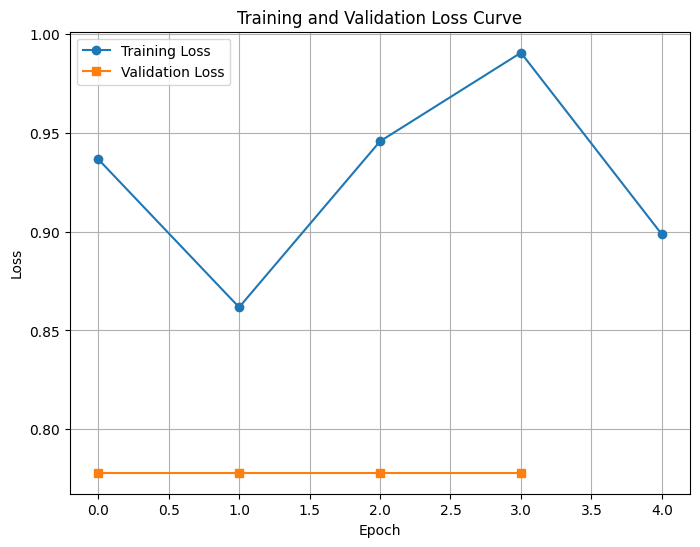

0.7779088

In [86]:
model_config = {'input_dim':16,
                'embed_dim':64,
                'n_heads':4,
                'tf_num_layers':3,
                'grid_size':(8,9),
                'seq_len':168,
                'dropout':0.1,
                'pred_hours':3,
                }

trainner_config = {'lr':1e-3,
                    'scheduler_name':'cos',
                    'scheduler_max_step':20,
                    'scheduler_min_lr':1e-9,
                    'max_epoch':5,
                    'exit_count':3,
                    'model_name':'best_model_weights.pt',
                    'output_filaname':'output.txt',
                    'loss_plot':'loss.png',
                    'show':True,
                    'gradient_clip':True,
                    'max_gradient_norm':1,
                    'gamma':2,
                    'poly_power':2,
                    'mixed_percision_type':torch.bfloat16
                    }



model = CombinedGridLoadPredictor(model_config)

optimizer = torch.optim.Adam(model.parameters(), lr = trainner_config['lr'])
scaler = torch.cuda.amp.GradScaler(enabled=True)

trainner = Trainner(model = CombinedGridLoadPredictor(model_config),
                    optim = optimizer,
                    scaler = scaler,
                    device = 'cpu',
                    loss_fn = Customized_MAE(),
                    trainning_dataloader = trainning_dataloader,
                    validation_dataloader = validation_dataloader,
                    testing_dataloader = None,
                    **trainner_config)

trainner.train_main()

# for batch in trainning_dataloader:
#     # print(batch['raw_data_weather'].shape)

#     input_data = batch['raw_data_weather']
#     month = batch['label_month']
#     day = batch['label_day']
#     hour = batch['label_hour']

#     # print(batch['train_month'].shape)
#     # print(hour)

#     pred = model(batch)
#     print(pred.shape)

#     # print(latent_output.shape)  # (batch_size, embed_dim)
#     break